In [1]:
## UTIL

import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from PIL import Image
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision
import json

In [3]:
import torch
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter(log_dir="./logs")

sam_version = "l"

if (sam_version == "l"):
	model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

	sam = sam_model_registry["vit_l"](checkpoint="./model/sam_vit_l_0b3195.pth")
	print("Using sam_vit_large")
else: 
	model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

	sam = sam_model_registry["vit_b"](checkpoint="./model/sam_vit_b_01ec64.pth")
	print("Using sam_vit_base")
 
sam.to(device=device)
predictor = SamPredictor(sam)

Using sam_vit_large


In [4]:
torch.cuda.is_available()

True

In [5]:
# Loss Definition

import torch.nn.functional as F 

def compute_loss(pred_masks, true_masks, pred_scores, true_scores):

  mask_loss = F.binary_cross_entropy_with_logits(pred_masks, true_masks)
  score_loss = F.mse_loss(pred_scores, true_scores)
  
  return mask_loss + score_loss

In [6]:
# Add images and masks to array

import os

panos_dirs = []
masks_dirs = []

training_dir = "./data/training/"
training_folder = ["0000", "0001"]

for item in training_folder:
  panos_dirs.append(training_dir + item + "/cropped_panos")
  masks_dirs.append(training_dir + item + "/cropped_masks")

image_paths = []
mask_paths = []

for i in range(len(panos_dirs)):
	for filename in os.listdir(panos_dirs[i]):
		if filename.endswith((".jpg", ".png")):
			image_path = os.path.join(panos_dirs[i], filename)
			mask_name = f"{os.path.splitext(filename)[0]}.json" 
			mask_path = os.path.join(masks_dirs[i], mask_name)

			if os.path.exists(mask_path):
					image_paths.append(image_path)
					mask_paths.append(mask_path)
			else:
					print(f"No mask for {image_path} found")

print(f"Amount of images found: {len(image_paths)}")
print(f"Amount of masks found: {len(mask_paths)}")


Amount of images found: 360
Amount of masks found: 360


In [7]:
# Dataset definition

class WindowSegmentationDataset(Dataset):
	def __init__(self, image_paths, mask_paths, transform=None):
		self.image_paths = image_paths
		self.mask_paths = mask_paths
		self.transform = transform
	
	def __len__(self):
		return len(self.image_paths)
	
	def load_mask_from_json(self, json_path, image_size):
		with open(json_path, 'r') as f:
			data = json.load(f)
			
		mask = np.zeros(image_size, dtype=np.uint8)
		
		for shape in data['shapes']:
			points = np.array(shape['points'], dtype=np.int32)
			cv2.fillPoly(mask, [points], 1)
			
		mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
		return mask
			
	def __getitem__(self, idx):
		image = Image.open(self.image_paths[idx]).convert("RGB")
		json_path = self.mask_paths[idx]
		
		if (self.transform):
			image = self.transform(image)
   
		image_size = (image.shape[1], image.shape[2])
		mask = self.load_mask_from_json(json_path, image_size)
			
		return image, mask

transform = transforms.Compose([
	transforms.Resize((250, 250)),
 	transforms.ToTensor(),
])

dataset = WindowSegmentationDataset(image_paths, mask_paths, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
# Training

model.train()
optimizer = Adam(model.parameters(), lr=1e-4)

losses = []
accumulation_steps = 16

for epoch in range(5): 
	counter = 0
	running_loss = 0.0
	for i, (images, masks) in enumerate(data_loader):
		images, masks = images.to(device), masks.to(device)
		counter += 1
  
		inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
		image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
		outputs = model(**inputs)

		pred_masks = outputs.pred_masks

		# Choose best mask 
		scores = outputs.iou_scores.squeeze().tolist()
		max_index = scores.index(max(scores))
		best_mask = pred_masks[:, :, max_index]
 
		# Scale ground truth masks
		true_masks_resized = F.interpolate(masks, size=(256, 256), mode="bilinear", align_corners=False)
		true_masks_resized = (true_masks_resized > 0.5).float()

		# Loss calculation
		mask_loss = F.binary_cross_entropy_with_logits(best_mask, true_masks_resized)
		mask_loss = mask_loss / accumulation_steps
  
		losses.append(mask_loss.item())
		mask_loss.backward()
		running_loss += mask_loss.item()
  
		# Logging
		if i % 10 == 0:
			writer.add_scalar("Training loss", mask_loss.item(), epoch * len(data_loader) + i)
  
		#Backpropagation
		if (i + 1) % accumulation_steps == 0:
			optimizer.step()
			optimizer.zero_grad()
			writer.add_scalar("Epoch loss", running_loss / len(data_loader), epoch)
			running_loss = 0.0
  
		torch.cuda.empty_cache()
  
		# Display interim results

		img = inputs['pixel_values']
		img_grid = torchvision.utils.make_grid(img[:4])
		writer.add_image("Input Images", img_grid, epoch)
  
		mask = outputs.pred_masks.squeeze(0)
		mask = mask[0]
		mask_grid = torchvision.utils.make_grid(mask[:4])
		writer.add_image("Predicted Masks", mask_grid, epoch)
 
	# Leftover steps
	if (i + 1) % accumulation_steps != 0:
		optimizer.step()
		optimizer.zero_grad()
  
  
	print(f"Epoch: {epoch}")


# After training is done
torch.save(model.state_dict(), "./model/first_run_large.pth")

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


413min(6,8 Std), Large, 5 Epochen, 16 SegSteps

In [ ]:
# After training is done
torch.save(model.state_dict(), "./model/first_run_large.pth")

In [ ]:
# Initialize the model (same architecture)
model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)

# Load the saved model weights
model.load_state_dict(torch.load("model_weights.pth"))

# Set the model to evaluation mode if you're doing inference
model.eval()

In [4]:
checkpoint = torch.load("./model/model_weights_base.pth", map_location="cpu")
print(checkpoint.keys())


odict_keys(['shared_image_embedding.positional_embedding', 'vision_encoder.pos_embed', 'vision_encoder.patch_embed.projection.weight', 'vision_encoder.patch_embed.projection.bias', 'vision_encoder.layers.0.layer_norm1.weight', 'vision_encoder.layers.0.layer_norm1.bias', 'vision_encoder.layers.0.attn.rel_pos_h', 'vision_encoder.layers.0.attn.rel_pos_w', 'vision_encoder.layers.0.attn.qkv.weight', 'vision_encoder.layers.0.attn.qkv.bias', 'vision_encoder.layers.0.attn.proj.weight', 'vision_encoder.layers.0.attn.proj.bias', 'vision_encoder.layers.0.layer_norm2.weight', 'vision_encoder.layers.0.layer_norm2.bias', 'vision_encoder.layers.0.mlp.lin1.weight', 'vision_encoder.layers.0.mlp.lin1.bias', 'vision_encoder.layers.0.mlp.lin2.weight', 'vision_encoder.layers.0.mlp.lin2.bias', 'vision_encoder.layers.1.layer_norm1.weight', 'vision_encoder.layers.1.layer_norm1.bias', 'vision_encoder.layers.1.attn.rel_pos_h', 'vision_encoder.layers.1.attn.rel_pos_w', 'vision_encoder.layers.1.attn.qkv.weight', 

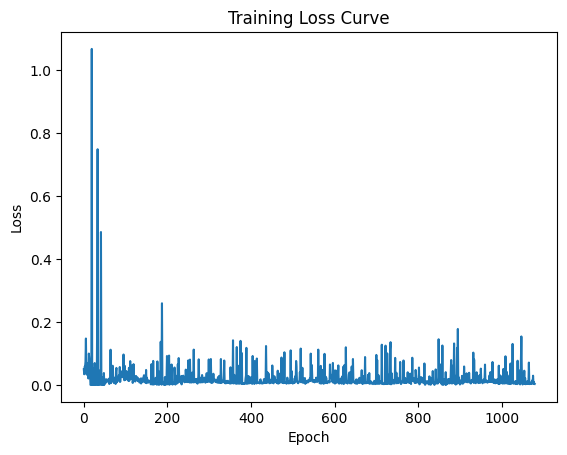

[0.04975100979208946, 0.03386780992150307, 0.05800062417984009, 0.05850798636674881, 0.0737839788198471, 0.14729207754135132, 0.04832068830728531, 0.032800573855638504, 0.06955862045288086, 0.03843263164162636, 0.031283412128686905, 0.020436637103557587, 0.09950800985097885, 0.0847308486700058, 0.05805014818906784, 0.0364159494638443, 1.2732925824820995e-11, 3.637978807091713e-11, 0.015396974049508572, 1.0664987564086914, 0.0, 0.053376127034425735, 1.609805622138083e-10, 0.008396856486797333, 0.0, 1.317857822868973e-09, 0.06945247948169708, 0.004999700468033552, 0.0, 1.0277290130034089e-10, 1.0304574971087277e-09, 5.57520252186805e-10, 0.21876657009124756, 0.7480888366699219, 9.106315701501444e-08, 0.04763715714216232, 0.0003076666034758091, 2.191718522226438e-07, 1.6919693734962493e-07, 0.009584354236721992, 0.021999862045049667, 0.4853092432022095, 4.96847860631533e-08, 8.22155925561674e-08, 3.861123332171701e-05, 2.1046116671641357e-06, 0.024867815896868706, 1.505018644820666e-06, 0

In [13]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()
print(losses)

Text(0.5, 1.0, 'Original Image')

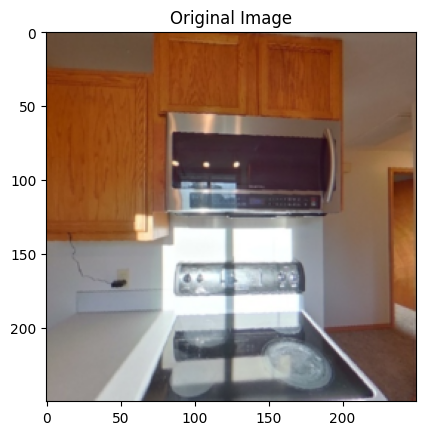

In [28]:
plt.imshow(images[0].cpu().permute(1, 2, 0))  # Original image
plt.title("Original Image")

Text(0.5, 1.0, 'Mask')

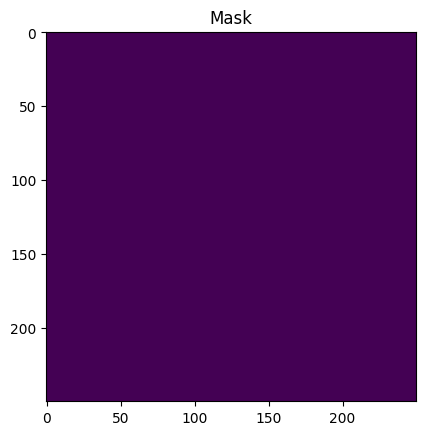

In [29]:
plt.imshow(masks[0].cpu().permute(1, 2, 0))  # Original image
plt.title("Mask")